In [ ]:
# SCRIPT PARA DESCOBRIR AS MÉTRICAS DISPONÍVEIS NO PROMETHEUS

import requests
import re

def discover_memory_metrics(prometheus_url):
    """
    Descobre todas as métricas de memória disponíveis no Prometheus
    """
    print("🔍 Descobrindo métricas de memória disponíveis...")
    
    try:
        # Buscar todas as métricas
        response = requests.get(f"{prometheus_url}/api/v1/label/__name__/values", timeout=10)
        
        if response.status_code != 200:
            print(f"❌ Erro: {response.status_code}")
            return []
        
        data = response.json()
        all_metrics = data['data']
        
        # Filtrar métricas relacionadas à memória
        memory_metrics = []
        memory_patterns = [
            r'.*memory.*',
            r'.*mem.*',
            r'.*oom.*',
            r'.*swap.*',
            r'.*rss.*',
            r'.*cache.*',
            r'.*slab.*'
        ]
        
        for metric in all_metrics:
            for pattern in memory_patterns:
                if re.match(pattern, metric, re.IGNORECASE):
                    if 'container' in metric or 'node' in metric:
                        memory_metrics.append(metric)
                    break
        
        # Remover duplicatas e ordenar
        memory_metrics = sorted(list(set(memory_metrics)))
        
        print(f"✅ Encontradas {len(memory_metrics)} métricas de memória:")
        
        for metric in memory_metrics:
            print(f"   📊 {metric}")
     
        return memory_metrics
        
    except Exception as e:
        print(f"❌ Erro ao descobrir métricas: {e}")
        return []

def get_metric_samples(prometheus_url, metric_name, limit=3):
    """
    Obtém amostras de uma métrica específica
    """
    try:
        params = {'query': metric_name}
        response = requests.get(f"{prometheus_url}/api/v1/query", params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'success' and data['data']['result']:
                results = data['data']['result'][:limit]
                
                print(f"\n📊 Amostras da métrica '{metric_name}':")
                for i, result in enumerate(results, 1):
                    metric_labels = result['metric']
                    value = result['value'][1]
                    
                    # Mostrar labels principais
                    key_labels = {k: v for k, v in metric_labels.items() 
                                if k in ['pod', 'container', 'instance', 'namespace']}
                    
                    print(f"   {i}. Valor: {value} | Labels: {key_labels}")
                
                return True
        
        return False
        
    except Exception as e:
        print(f"❌ Erro ao obter amostras: {e}")
        return False

# Uso do script
if __name__ == "__main__":
    PROMETHEUS_URL = "http://localhost:9090"
    
    # Descobrir métricas
    metrics = discover_memory_metrics(PROMETHEUS_URL)
    
    # Mostrar amostras das métricas principais
    main_metrics = [
        'container_memory_usage_bytes',
        'container_memory_working_set_bytes',
        'container_memory_rss',
        'container_memory_cache'
    ]
    
    print("\n" + "="*80)
    print("📋 AMOSTRAS DAS MÉTRICAS PRINCIPAIS")
    print("="*80)
    
    for metric in main_metrics:
        if metric in metrics:
            get_metric_samples(PROMETHEUS_URL, metric)

🔍 Descobrindo métricas de memória disponíveis...
✅ Encontradas 76 métricas de memória:
   📊 :node_memory_MemAvailable_bytes:sum
   📊 cluster:namespace:pod_memory:active:kube_pod_container_resource_limits
   📊 cluster:namespace:pod_memory:active:kube_pod_container_resource_requests
   📊 container_memory_cache
   📊 container_memory_failcnt
   📊 container_memory_failures_total
   📊 container_memory_kernel_usage
   📊 container_memory_max_usage_bytes
   📊 container_memory_rss
   📊 container_memory_total_active_file_bytes
   📊 container_memory_total_inactive_file_bytes
   📊 container_memory_usage_bytes
   📊 container_memory_working_set_bytes
   📊 container_oom_events_total
   📊 instance:node_memory_utilisation:ratio
   📊 namespace_memory:kube_pod_container_resource_limits:sum
   📊 namespace_memory:kube_pod_container_resource_requests:sum
   📊 node_memory_Active_anon_bytes
   📊 node_memory_Active_bytes
   📊 node_memory_Active_file_bytes
   📊 node_memory_AnonHugePages_bytes
   📊 node_memory_An

In [6]:
import requests
import pandas as pd
from datetime import datetime

# URL da API Prometheus
url = 'http://localhost:9090/api/v1/query?query=container_cpu_usage_seconds_total{pod=~".*postgres.*"}[10m]'

# Fazendo a requisição GET
response = requests.get(url)
data = response.json()  # Converte a resposta para dict

# Verifica se há resultados e estrutura esperada
results = data.get('data', {}).get('result', [])

# Lista para armazenar os registros
records = []

# Processa cada resultado
for item in results:
    # Extrai a série temporal (samples)
    for value in item.get('values', []):
        ts = float(value[0])  # Timestamp UNIX
        cpu_val = float(value[1])
        # Converte timestamp para Data/Hora legível
        dt = datetime.utcfromtimestamp(ts)
        
        # Extrai o nome do pod dos labels
        pod_name = item['metric'].get('pod', 'N/A')
        records.append({"timestamp": dt, "pod": pod_name, "cpu": cpu_val})

# Cria DataFrame
df = pd.DataFrame(records)
#df = df.sort_values(by='timestamp', ascending=False)
# Mostra resultado
df

,timestamp,pod,cpu
0,2025-10-01 21:34:55.450,postgres-deployment-76d6f4778d-qxm7b,0.748982
1,2025-10-01 21:35:09.905,postgres-deployment-76d6f4778d-qxm7b,0.749272
2,2025-10-01 21:35:21.713,postgres-deployment-76d6f4778d-qxm7b,0.749366
3,2025-10-01 21:35:32.389,postgres-deployment-76d6f4778d-qxm7b,0.749457
4,2025-10-01 21:35:50.933,postgres-deployment-76d6f4778d-qxm7b,0.749676
...,...,...,...
107,2025-10-01 21:43:38.225,postgres-deployment-76d6f4778d-qxm7b,0.115790
108,2025-10-01 21:43:54.481,postgres-deployment-76d6f4778d-qxm7b,0.115790
109,2025-10-01 21:44:10.743,postgres-deployment-76d6f4778d-qxm7b,0.115790
110,2025-10-01 21:44:33.055,postgres-deployment-76d6f4778d-qxm7b,0.115790


In [7]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import re

def query_prometheus_memory_with_instance(prometheus_url, pod_name, time_range="30m"):
    """
    Consulta memória do pod incluindo informações detalhadas de instance
    """
    print(f"\n🔍 Consultando memória do pod: {pod_name}")
    
    # Calcular timestamps Unix
    end_time = int(time.time())
    seconds = parse_time_range(time_range)
    start_time = end_time - seconds
    
    # Construir a query
    query = f'container_memory_usage_bytes{{pod="{pod_name}", container!="POD", container!=""}}'
    
    # Parâmetros com timestamps Unix
    params = {
        'query': query,
        'start': str(start_time),
        'end': str(end_time),
        'step': '30s'
    }
    
    api_url = f"{prometheus_url}/api/v1/query_range"
    
    print(f"🌐 URL da consulta: {api_url}")
    print(f"📋 Query: {query}")
    print(f"⏰ Start: {start_time} ({datetime.fromtimestamp(start_time)})")
    print(f"⏰ End: {end_time} ({datetime.fromtimestamp(end_time)})")
    print(f"📊 Período: {time_range}")
    
    try:
        print("📡 Fazendo requisição...")
        response = requests.get(api_url, params=params, timeout=30)
        
        print(f"📊 Status HTTP: {response.status_code}")
        
        if response.status_code != 200:
            print(f"❌ Erro HTTP {response.status_code}")
            print(f"Resposta: {response.text}")
            return pd.DataFrame()
        
        data = response.json()
        
        if data['status'] != 'success':
            print(f"❌ Erro na query Prometheus: {data.get('error', 'Erro desconhecido')}")
            print(f"Tipo do erro: {data.get('errorType', 'N/A')}")
            return pd.DataFrame()
        
        results = data['data']['result']
        
        if not results:
            print("⚠️  Nenhum dado encontrado para este pod")
            return pd.DataFrame()
        
        print(f"✅ Encontrados {len(results)} séries de dados")
        
        # Mostrar informações das instances encontradas
        instances_found = set()
        for result in results:
            metric = result['metric']
            instance = metric.get('instance', 'N/A')
            container = metric.get('container', 'N/A')
            instances_found.add(f"{instance} (container: {container})")
        
        print("\n🖥️  Instances encontradas:")
        for instance_info in sorted(instances_found):
            print(f"   📍 {instance_info}")
        
        # Processar dados
        processed_data = []
        
        for result in results:
            metric = result['metric']
            values = result['values']
            
            # Extrair todas as informações disponíveis da métrica
            pod_name_found = metric.get('pod', 'N/A')
            instance = metric.get('instance', 'N/A')
            container = metric.get('container', 'N/A')
            namespace = metric.get('namespace', 'N/A')
            node = metric.get('node', 'N/A')
            job = metric.get('job', 'N/A')
            
            # Separar IP e porta da instance (se disponível)
            instance_ip = 'N/A'
            instance_port = 'N/A'
            if instance and instance != 'N/A' and ':' in instance:
                try:
                    instance_ip, instance_port = instance.split(':')
                except:
                    instance_ip = instance
            elif instance and instance != 'N/A':
                instance_ip = instance
            
            print(f"📦 Processando - Container: {container}, Instance: {instance}")
            
            for timestamp, memory_bytes in values:
                try:
                    dt_utc = datetime.utcfromtimestamp(float(timestamp))
                    processed_data.append({
                        'pod_name': pod_name_found,
                        'instance': instance,
                        'instance_ip': instance_ip,
                        'instance_port': instance_port,
                        'container': container,
                        'namespace': namespace,
                        'node': node,
                        'job': job,
                        'datetime_utc': dt_utc.strftime('%Y-%m-%d %H:%M:%S'),
                        'timestamp': float(timestamp),
                        'memory_bytes': float(memory_bytes),
                        'memory_mb': round(float(memory_bytes) / (1024 * 1024), 2),
                        'memory_gb': round(float(memory_bytes) / (1024 * 1024 * 1024), 4)
                    })
                except (ValueError, TypeError) as e:
                    print(f"⚠️  Erro ao processar ponto de dados: {e}")
                    continue
        
        if not processed_data:
            print("❌ Nenhum dado válido foi processado")
            return pd.DataFrame()
        
        df = pd.DataFrame(processed_data)
        df = df.sort_values(['instance', 'container', 'timestamp']).reset_index(drop=True)
        
        print(f"✅ Dataset criado com {len(df)} registros")
        return df
        
    except Exception as e:
        print(f"❌ Erro inesperado: {e}")
        return pd.DataFrame()

def parse_time_range(time_range):
    """
    Converte time_range (ex: "30m", "1h", "2d") para segundos
    """
    match = re.match(r'(\d+)([smhd])', time_range.lower())
    if not match:
        raise ValueError(f"Formato de time_range inválido: {time_range}")
    
    value = int(match.group(1))
    unit = match.group(2)
    
    multipliers = {
        's': 1,      # segundos
        'm': 60,     # minutos
        'h': 3600,   # horas
        'd': 86400   # dias
    }
    
    return value * multipliers[unit]

def show_instance_summary(df):
    """
    Mostra resumo das instances encontradas
    """
    if df.empty:
        return
    
    print("\n" + "="*80)
    print("🖥️  RESUMO DAS INSTANCES")
    print("="*80)
    
    # Agrupar por instance
    instance_summary = df.groupby(['instance', 'container']).agg({
        'memory_mb': ['min', 'max', 'mean', 'count'],
        'pod_name': 'first',
        'namespace': 'first',
        'node': 'first'
    }).round(2)
    
    # Flatten column names
    instance_summary.columns = ['_'.join(col).strip() for col in instance_summary.columns.values]
    instance_summary = instance_summary.reset_index()
    
    for _, row in instance_summary.iterrows():
        print(f"\n📍 Instance: {row['instance']}")
        print(f"   �� Container: {row['container']}")
        print(f"   🏷️  Pod: {row['pod_name_first']}")
        print(f"   📂 Namespace: {row['namespace_first']}")
        print(f"   🖥️  Node: {row['node_first']}")
        print(f"   📊 Memória - Min: {row['memory_mb_min']} MB | Max: {row['memory_mb_max']} MB | Média: {row['memory_mb_mean']} MB")
        print(f"   📈 Registros: {int(row['memory_mb_count'])}")

def list_postgres_pods_with_instances(prometheus_url):
    """
    Lista pods PostgreSQL com suas respectivas instances
    """
    print("\n🔍 Buscando pods PostgreSQL e suas instances...")
    
    query = 'container_memory_usage_bytes{container!="POD", container!=""}'
    params = {'query': query}
    api_url = f"{prometheus_url}/api/v1/query"
    
    try:
        response = requests.get(api_url, params=params, timeout=15)
        
        if response.status_code != 200:
            print(f"❌ Erro ao listar pods: {response.status_code}")
            return []
        
        data = response.json()
        
        if data['status'] != 'success':
            print(f"❌ Erro na query: {data.get('error')}")
            return []
        
        # Extrair pods PostgreSQL com instances
        postgres_info = []
        all_pods_info = []
        
        for result in data['data']['result']:
            metric = result['metric']
            pod_name = metric.get('pod', '')
            instance = metric.get('instance', 'N/A')
            container = metric.get('container', 'N/A')
            namespace = metric.get('namespace', 'N/A')
            
            pod_info = {
                'pod': pod_name,
                'instance': instance,
                'container': container,
                'namespace': namespace
            }
            
            if pod_name:
                all_pods_info.append(pod_info)
                if 'postgres' in pod_name.lower():
                    postgres_info.append(pod_info)
        
        if postgres_info:
            print("✅ Pods PostgreSQL encontrados:")
            for info in postgres_info:
                print(f"   📦 Pod: {info['pod']}")
                print(f"      📍 Instance: {info['instance']}")
                print(f"      🔧 Container: {info['container']}")
                print(f"      📂 Namespace: {info['namespace']}")
                print()
        else:
            print("⚠️  Nenhum pod PostgreSQL encontrado")
            print("💡 Pods disponíveis (primeiros 5):")
            for info in all_pods_info[:5]:
                print(f"   📦 Pod: {info['pod']} | Instance: {info['instance']}")
        
        return [info['pod'] for info in postgres_info]
        
    except Exception as e:
        print(f"❌ Erro ao listar pods: {e}")
        return []

def main():
    # Configurações
    PROMETHEUS_URL = "http://localhost:9090"
    
    print("🚀 Iniciando consulta ao Prometheus com informações de Instance")
    print("=" * 80)
    
    # Listar pods PostgreSQL com instances
    postgres_pods = list_postgres_pods_with_instances(PROMETHEUS_URL)
    
    if postgres_pods:
        pod_name = postgres_pods[0]
        print(f"\n✅ Usando pod: {pod_name}")
    else:
        pod_name = input("\nDigite o nome exato do pod PostgreSQL: ").strip()
        if not pod_name:
            print("❌ Nome do pod não fornecido")
            return None
    
    # Executar consulta
    print("\n" + "=" * 80)
    df = query_prometheus_memory_with_instance(PROMETHEUS_URL, pod_name, "30m")
    
    if df.empty:
        print("❌ Nenhum dado foi retornado")
        return None
    
    # Mostrar resumo das instances
    show_instance_summary(df)
    
    # Exibir resultados detalhados
    print("\n" + "=" * 80)
    print("📊 DATASET COMPLETO")
    print("=" * 80)
    print(f"📈 Total de registros: {len(df)}")
    print(f"⏰ Período: {df['datetime_utc'].min()} até {df['datetime_utc'].max()}")
    print(f"🖥️  Instances únicas: {df['instance'].nunique()}")
    print(f"📦 Containers únicos: {df['container'].nunique()}")
    
    # Mostrar colunas disponíveis
    print(f"\n📋 Colunas do dataset:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\n📋 Primeiros 5 registros:")
    # Mostrar apenas colunas principais para visualização
    display_cols = ['pod_name', 'instance', 'container', 'datetime_utc', 'memory_mb']
    print(df[display_cols].head().to_string(index=False))
    
    print(f"\n📊 Estatísticas Gerais de Memória:")
    print(f"   �� Mínima: {df['memory_mb'].min():.2f} MB")
    print(f"   🔺 Máxima: {df['memory_mb'].max():.2f} MB")
    print(f"   📊 Média: {df['memory_mb'].mean():.2f} MB")
    print(f"   📏 Desvio Padrão: {df['memory_mb'].std():.2f} MB")
    
    # Salvar arquivo com timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"postgres_memory_with_instances_{timestamp}.csv"
    df.to_csv(output_file, index=False)
    print(f"\n�� Dataset completo salvo em: {output_file}")
    
    # Salvar resumo por instance
    summary_file = f"postgres_instances_summary_{timestamp}.csv"
    instance_summary = df.groupby(['instance', 'container']).agg({
        'memory_mb': ['min', 'max', 'mean', 'std', 'count'],
        'pod_name': 'first',
        'namespace': 'first',
        'node': 'first'
    }).round(2)
    instance_summary.to_csv(summary_file)
    print(f"💾 Resumo por instance salvo em: {summary_file}")
    
    return df

if __name__ == "__main__":
    dataset = main()
    
    # Exemplo de como filtrar por instance específica
    if dataset is not None and not dataset.empty:
        print("\n" + "="*80)
        print("💡 EXEMPLO: Como filtrar por instance específica")
        print("="*80)
        
        instances = dataset['instance'].unique()
        if len(instances) > 0:
            example_instance = instances[0]
            filtered_df = dataset[dataset['instance'] == example_instance]
            print(f"Dados filtrados para instance '{example_instance}':")
            print(f"Total de registros: {len(filtered_df)}")
            print(filtered_df[['datetime_utc', 'container', 'memory_mb']].head(3).to_string(index=False))

🚀 Iniciando consulta ao Prometheus com informações de Instance

🔍 Buscando pods PostgreSQL e suas instances...
✅ Pods PostgreSQL encontrados:
   📦 Pod: postgres-deployment-76d6f4778d-qxm7b
      📍 Instance: 192.168.242.134:10250
      🔧 Container: postgres
      📂 Namespace: default


✅ Usando pod: postgres-deployment-76d6f4778d-qxm7b


🔍 Consultando memória do pod: postgres-deployment-76d6f4778d-qxm7b
🌐 URL da consulta: http://localhost:9090/api/v1/query_range
📋 Query: container_memory_usage_bytes{pod="postgres-deployment-76d6f4778d-qxm7b", container!="POD", container!=""}
⏰ Start: 1759353360 (2025-10-01 21:16:00)
⏰ End: 1759355160 (2025-10-01 21:46:00)
📊 Período: 30m
📡 Fazendo requisição...
📊 Status HTTP: 200
✅ Encontrados 1 séries de dados

🖥️  Instances encontradas:
   📍 192.168.242.134:10250 (container: postgres)
📦 Processando - Container: postgres, Instance: 192.168.242.134:10250
✅ Dataset criado com 61 registros

🖥️  RESUMO DAS INSTANCES

📍 Instance: 192.168.242.134:10250
   �� 

In [ ]:
df

,timestamp,pod,cpu
0,2025-09-07 11:35:13.859,postgres-deployment-76d6f4778d-ccs8g,32.653251
1,2025-09-07 11:35:33.830,postgres-deployment-76d6f4778d-ccs8g,32.658900
2,2025-09-07 11:35:46.481,postgres-deployment-76d6f4778d-ccs8g,32.661028
3,2025-09-07 11:36:00.848,postgres-deployment-76d6f4778d-ccs8g,32.663194
4,2025-09-07 11:36:17.275,postgres-deployment-76d6f4778d-ccs8g,32.665445
...,...,...,...
102,2025-09-07 11:43:37.589,postgres-deployment-76d6f4778d-ccs8g,0.054616
103,2025-09-07 11:43:52.151,postgres-deployment-76d6f4778d-ccs8g,0.054616
104,2025-09-07 11:44:12.135,postgres-deployment-76d6f4778d-ccs8g,0.054616
105,2025-09-07 11:44:23.583,postgres-deployment-76d6f4778d-ccs8g,0.054616


In [16]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.7 MB/s eta 0:00:00a 0:00:01


🚀 Gerando Gráficos de Memória vs Tempo
🔍 Consultando dados para gráfico - Pod: cpu-stress-test
✅ 369 registros coletados para 1 containers

📊 Resumo dos dados coletados:
   📈 Total de registros: 369
   ⏰ Período: 2025-09-08 19:11:49 até 2025-09-08 21:21:49
   📦 Containers: cpu-stress
   🖥️  Instances: x86

📊 Gerando gráficos...
📊 Criando gráfico de linha...
📊 Gráfico salvo como: postgres_memory_chart_20250908_182149.png


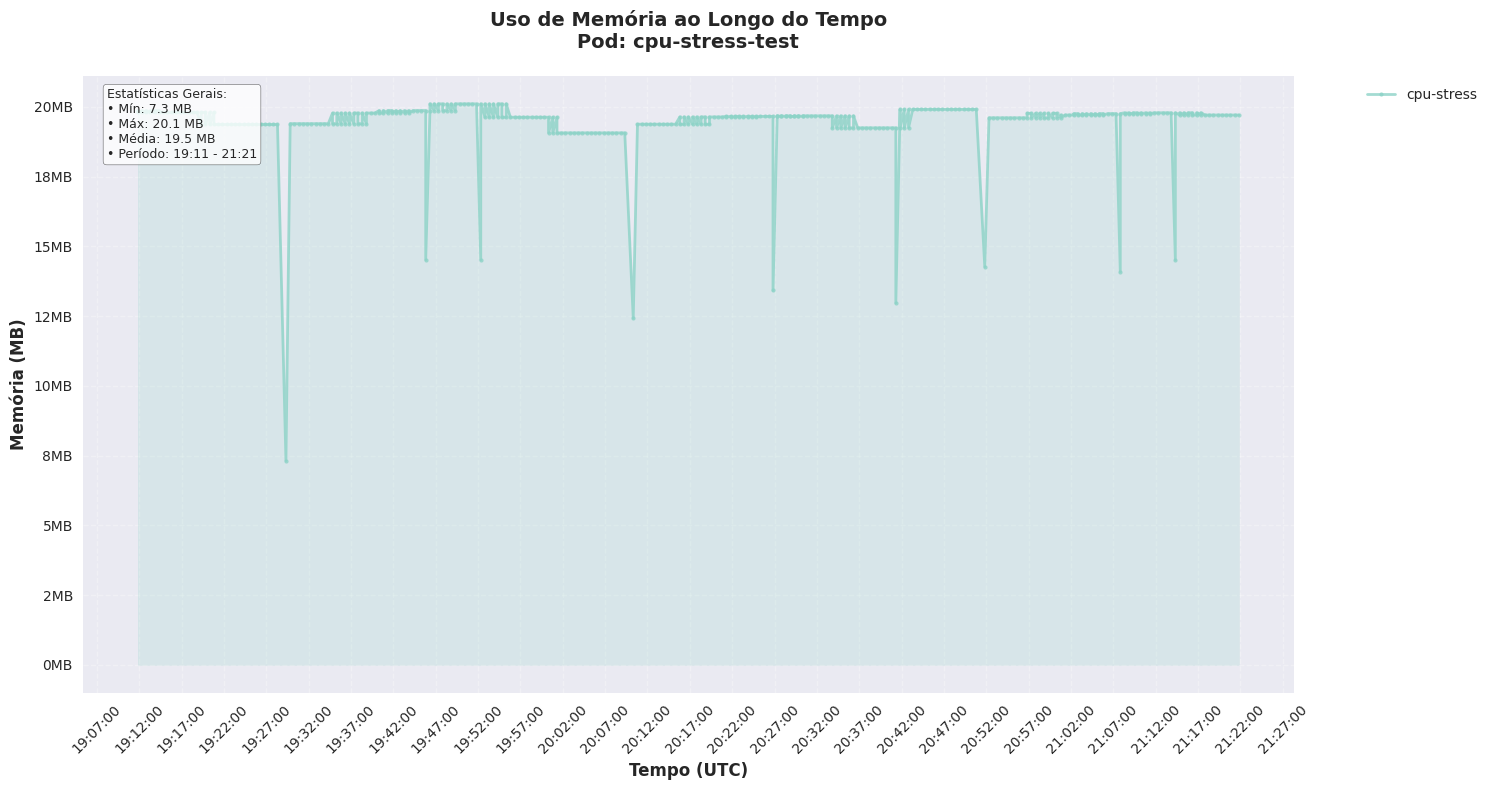

📊 Criando histograma de distribuição...
📊 Histograma salvo: postgres_memory_distribution_20250908_182149.png


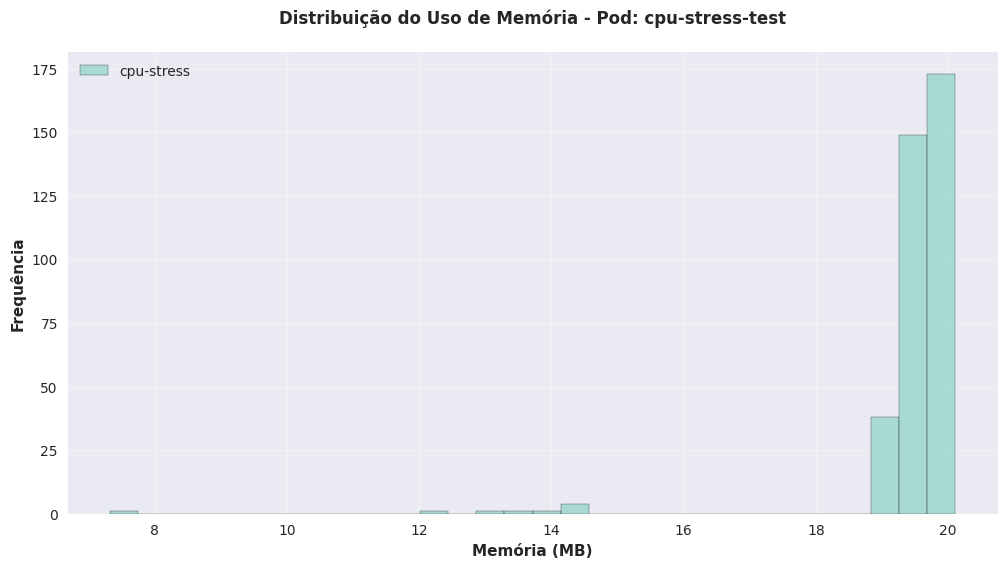


✅ Gráficos gerados com sucesso!


In [7]:
import requests
import pandas as pd
from datetime import datetime
import time
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns

def query_prometheus_memory_for_chart(prometheus_url, pod_name, time_range="30m"):
    """
    Consulta dados do Prometheus para gerar gráfico
    """
    print(f"🔍 Consultando dados para gráfico - Pod: {pod_name}")
    
    # Calcular timestamps
    end_time = int(time.time())
    seconds = parse_time_range(time_range)
    start_time = end_time - seconds

  

    query = f'container_memory_usage_bytes{{pod=~".*{pod_name}.*", container!="POD", container!=""}}'
    
    params = {
        'query': query,
        'start': str(start_time),
        'end': str(end_time),
        'step': '30s'
    }
    
    api_url = f"{prometheus_url}/api/v1/query_range"
    
    try:
        response = requests.get(api_url, params=params, timeout=30)
        
        if response.status_code != 200:
            print(f"❌ Erro HTTP {response.status_code}")
            return pd.DataFrame()
        
        data = response.json()
        
        if data['status'] != 'success':
            print(f"❌ Erro Prometheus: {data.get('error')}")
            return pd.DataFrame()
        
        results = data['data']['result']
        
        if not results:
            print("⚠️  Nenhum dado encontrado")
            return pd.DataFrame()
        
        processed_data = []
        
        for result in results:
            metric = result['metric']
            values = result['values']
            
            pod_name_found = metric.get('pod', 'N/A')
            instance = metric.get('instance', 'N/A')
            container = metric.get('container', 'N/A')
            
            for timestamp, memory_bytes in values:
                try:
                    dt_utc = datetime.utcfromtimestamp(float(timestamp))
                    processed_data.append({
                        'pod_name': pod_name_found,
                        'instance': instance,
                        'container': container,
                        'datetime': dt_utc,
                        'timestamp': float(timestamp),
                        'memory_bytes': float(memory_bytes),
                        'memory_mb': round(float(memory_bytes) / (1024 * 1024), 2),
                        'memory_gb': round(float(memory_bytes) / (1024 * 1024 * 1024), 4)
                    })
                except (ValueError, TypeError):
                    continue
        
        if not processed_data:
            return pd.DataFrame()
        
        df = pd.DataFrame(processed_data)
        df = df.sort_values(['container', 'timestamp']).reset_index(drop=True)
        
        print(f"✅ {len(df)} registros coletados para {df['container'].nunique()} containers")
        return df
        
    except Exception as e:
        print(f"❌ Erro: {e}")
        return pd.DataFrame()

def parse_time_range(time_range):
    """Converte time_range para segundos"""
    match = re.match(r'(\d+)([smhd])', time_range.lower())
    if not match:
        raise ValueError(f"Formato inválido: {time_range}")
    
    value = int(match.group(1))
    unit = match.group(2)
    
    multipliers = {'s': 1, 'm': 60, 'h': 3600, 'd': 86400}
    return value * multipliers[unit]

def create_memory_time_chart(df, pod_name, save_file=True):
    """
    Cria gráfico de tempo vs memória
    """
    if df.empty:
        print("❌ Sem dados para gerar gráfico")
        return None
    
    # Configurar estilo
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Criar figura
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Agrupar por container
    containers = df['container'].unique()
    colors = plt.cm.Set3(range(len(containers)))
    
    for i, container in enumerate(containers):
        container_data = df[df['container'] == container].copy()
        container_data = container_data.sort_values('datetime')
        
        # Plotar linha
        ax.plot(container_data['datetime'], 
                container_data['memory_mb'],
                label=f'{container}',
                linewidth=2,
                marker='o',
                markersize=3,
                color=colors[i],
                alpha=0.8)
        
        # Adicionar área sombreada
        ax.fill_between(container_data['datetime'], 
                       container_data['memory_mb'],
                       alpha=0.2,
                       color=colors[i])
    
    # Configurar eixos
    ax.set_xlabel('Tempo (UTC)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Memória (MB)', fontsize=12, fontweight='bold')
    ax.set_title(f'Uso de Memória ao Longo do Tempo\nPod: {pod_name}', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Formatação do eixo X (tempo)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    plt.xticks(rotation=45)
    
    # Formatação do eixo Y (memória)
    def format_mb(x, p):
        if x >= 1000:
            return f'{x/1000:.1f}GB'
        return f'{x:.0f}MB'
    
    ax.yaxis.set_major_formatter(FuncFormatter(format_mb))
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Legenda
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    # Estatísticas no gráfico
    stats_text = f"""Estatísticas Gerais:
• Mín: {df['memory_mb'].min():.1f} MB
• Máx: {df['memory_mb'].max():.1f} MB  
• Média: {df['memory_mb'].mean():.1f} MB
• Período: {df['datetime'].min().strftime('%H:%M')} - {df['datetime'].max().strftime('%H:%M')}"""
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', 
            facecolor='white', alpha=0.8), fontsize=9)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Salvar arquivo
    if save_file:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'postgres_memory_chart_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"📊 Gráfico salvo como: {filename}")
    
    plt.show()
    return fig

def create_multiple_charts(df, pod_name):
    """
    Cria múltiplos tipos de gráficos
    """
    if df.empty:
        return
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # 1. Gráfico de linha principal
    print("📊 Criando gráfico de linha...")
    create_memory_time_chart(df, pod_name, save_file=True)
    
    # 2. Gráfico por container (subplots)
    if df['container'].nunique() > 1:
        print("�� Criando gráficos separados por container...")
        
        containers = df['container'].unique()
        fig, axes = plt.subplots(len(containers), 1, figsize=(15, 4*len(containers)))
        
        if len(containers) == 1:
            axes = [axes]
        
        for i, container in enumerate(containers):
            container_data = df[df['container'] == container].copy()
            container_data = container_data.sort_values('datetime')
            
            axes[i].plot(container_data['datetime'], 
                        container_data['memory_mb'],
                        linewidth=2, marker='o', markersize=2)
            
            axes[i].fill_between(container_data['datetime'], 
                               container_data['memory_mb'], alpha=0.3)
            
            axes[i].set_title(f'Container: {container}', fontweight='bold')
            axes[i].set_ylabel('Memória (MB)')
            axes[i].grid(True, alpha=0.3)
            axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
            
            # Estatísticas por container
            stats = f"Min: {container_data['memory_mb'].min():.1f}MB | Max: {container_data['memory_mb'].max():.1f}MB | Média: {container_data['memory_mb'].mean():.1f}MB"
            axes[i].text(0.02, 0.95, stats, transform=axes[i].transAxes, 
                        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                        fontsize=8)
        
        plt.xlabel('Tempo (UTC)')
        plt.suptitle(f'Uso de Memória por Container - Pod: {pod_name}', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        filename = f'postgres_memory_by_container_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"📊 Gráfico por container salvo: {filename}")
        plt.show()
    
    # 3. Histograma de distribuição de memória
    print("📊 Criando histograma de distribuição...")
    
    plt.figure(figsize=(12, 6))
    
    containers = df['container'].unique()
    colors = plt.cm.Set3(range(len(containers)))
    
    for i, container in enumerate(containers):
        container_data = df[df['container'] == container]
        plt.hist(container_data['memory_mb'], bins=30, alpha=0.7, 
                label=container, color=colors[i], edgecolor='black')
    
    plt.xlabel('Memória (MB)', fontweight='bold')
    plt.ylabel('Frequência', fontweight='bold')
    plt.title(f'Distribuição do Uso de Memória - Pod: {pod_name}', 
              fontweight='bold', pad=20)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    filename = f'postgres_memory_distribution_{timestamp}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"📊 Histograma salvo: {filename}")
    plt.show()

def main():
    # Configurações
    PROMETHEUS_URL = "http://192.168.242.131:9090"
    POD_NAME = "cpu-stress-test"  # Ajuste conforme necessário
    TIME_RANGE = "130m"     # Período de consulta
    
    print("🚀 Gerando Gráficos de Memória vs Tempo")
    print("=" * 60)
    
    # Consultar dados
    df = query_prometheus_memory_for_chart(PROMETHEUS_URL, POD_NAME, TIME_RANGE)
    
    if df.empty:
        print("❌ Sem dados para gerar gráficos")
        return
    
    # Mostrar resumo dos dados
    print(f"\n📊 Resumo dos dados coletados:")
    print(f"   📈 Total de registros: {len(df)}")
    print(f"   ⏰ Período: {df['datetime'].min()} até {df['datetime'].max()}")
    print(f"   📦 Containers: {', '.join(df['container'].unique())}")
    print(f"   🖥️  Instances: {', '.join(df['instance'].unique())}")
    
    # Criar gráficos
    print(f"\n📊 Gerando gráficos...")
    create_multiple_charts(df, POD_NAME)
    
    print(f"\n✅ Gráficos gerados com sucesso!")
    
    return df

if __name__ == "__main__":
    # Instalar dependências necessárias:
    # pip install matplotlib seaborn requests pandas
    
    dataset = main()

In [6]:
!pip install prometheus_api_client pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 KB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 KB 10.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.9/789.9 KB 10.6 MB/s eta 0:00:00a 0:00:01


In [14]:
import pandas as pd
from prometheus_api_client import PrometheusConnect
from datetime import datetime, timedelta
import pytz # Para lidar com fusos horários

def get_pod_degradation_metrics(
    prometheus_url: str,
    pod_partial_name: str,
    namespace: str = ".*", # Opcional: regex para namespace (ex: "default", ".*" para todos)
    time_range_minutes: int = 60,
    step_seconds: int = 60
) -> pd.DataFrame:
    """
    Busca métricas chave do Prometheus (via cAdvisor) para pods que correspondem
    a um nome parcial, útil para analisar potencial degradação.

    Args:
        prometheus_url: URL do servidor Prometheus (ex: "http://localhost:9090").
        pod_partial_name: Uma string parcial para corresponder aos nomes dos pods (ex: "nginx").
        namespace: Expressão regular do namespace. Padrão ".*" busca em todos.
        time_range_minutes: Quantos minutos de dados históricos buscar.
        step_seconds: O intervalo em segundos entre cada ponto de dados.

    Returns:
        Um Pandas DataFrame onde cada linha é um timestamp e as colunas são
        as métricas agregadas para os pods correspondentes. Retorna um DataFrame vazio
        se nenhum dado for encontrado.
    """
    # Conecta ao Prometheus. disable_ssl=True se estiver usando HTTP.
    prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)

    # Define o intervalo de tempo para a consulta
    end_time = datetime.now(pytz.utc) # Usar timezone-aware datetime (UTC)
    start_time = end_time - timedelta(minutes=time_range_minutes)

    # Seletor base para pods e containers de aplicação (excluindo containers "pause")
    base_selector = (
        f'namespace=~"{namespace}", '
        f'pod=~".*{pod_partial_name}.*", '
        'container!~"POD|pause|k8s_POD.*|^$"'
    )

    # Define as queries PromQL para as métricas de degradação
    # Usamos 'sum(...) by (pod)' para agregar os dados de todos os containers de
    # aplicação dentro de um mesmo pod e, se múltiplos pods corresponderem,
    # eles aparecerão como séries separadas no DataFrame final.
    metrics_queries = {
     # " "cpu_usage_cores_1": 'sum(rate(container_cpu_usage_seconds_total{pod=~".*postgres.*",container!~"POD|^$|pause|k8s_POD.*"}[5m])) by (pod)',
         "cpu_usage_cores": f'sum(rate(container_cpu_usage_seconds_total{{{base_selector}}}[5m])) by (pod)',
         "memory_working_set_bytes": f'sum(container_memory_working_set_bytes{{{base_selector}}}) by (pod)',
         "cpu_throttled_rate_seconds_per_sec": f'sum(rate(container_cpu_cfs_throttled_seconds_total{{{base_selector}}}[5m])) by (pod)',
         "memory_fail_rate_per_sec": f'sum(rate(container_memory_failcnt{{{base_selector}}}[5m])) by (pod)',
         "network_receive_bytes_per_sec": f'sum(rate(container_network_receive_bytes_total{{{base_selector}}}[5m])) by (pod)',
         "network_transmit_bytes_per_sec": f'sum(rate(container_network_transmit_bytes_total{{{base_selector}}}[5m])) by (pod)',
         "filesystem_reads_bytes_per_sec": f'sum(rate(container_fs_reads_bytes_total{{{base_selector}}}[5m])) by (pod)',
         "filesystem_writes_bytes_per_sec": f'sum(rate(container_fs_writes_bytes_total{{{base_selector}}}[5m])) by (pod)',
    }
    print (metrics_queries)
    all_series_data = {}

    for metric_alias, query_string in metrics_queries.items():
        print(f"Buscando {metric_alias}...")
        try:
            # custom_query_range retorna uma lista de séries.
            # Cada série tem um dicionário 'metric' (com labels como nome do pod)
            # e uma lista 'values' ([timestamp, value]).
            metric_data = prom.custom_query_range(
                query=query_string,
                start_time=start_time,
                end_time=end_time,
                step=f"{step_seconds}s"
            )
            
            if not metric_data:
                print(f"Nenhum dado encontrado para {metric_alias}.")
                continue

            # Processa cada série encontrada (ex: para diferentes pods que correspondem ao nome parcial)
            for series in metric_data:
                pod_label = series['metric'].get('pod', 'unknown_pod')
                series_df = pd.DataFrame(series['values'], columns=['timestamp', 'value'])
                # Converte o timestamp Unix para datetime
                series_df['timestamp'] = pd.to_datetime(series_df['timestamp'], unit='s', utc=True)
                #series_df['timestamp'] = series_df['timestamp'].dt.tz_localize(None)
                series_df['value'] = pd.to_numeric(series_df['value'])
                
                # Armazena os dados, usando o nome do pod e o nome da métrica como nome da coluna
                col_name = f"{pod_label}_{metric_alias}"
                all_series_data[col_name] = series_df.set_index('timestamp')['value']

        except Exception as e:
            print(f"Erro ao buscar {metric_alias}: {e}")

    if not all_series_data:
        return pd.DataFrame()

    # Cria um índice de tempo abrangente para garantir que todos os dados sejam alinhados
    # even if some metrics have missing points.
    full_time_index = pd.to_datetime(pd.Series(range(int(start_time.timestamp()), int(end_time.timestamp()) + 1, step_seconds)), unit='s', utc=True)
    combined_df = pd.DataFrame(index=full_time_index)
    
    # Junta todas as séries em um único DataFrame, usando o timestamp como chave
    for col_name, series_data in all_series_data.items():
        combined_df = combined_df.join(series_data.rename(col_name), how='outer')

    combined_df.index.name = 'timestamp'
    combined_df = combined_df.sort_index()
    return combined_df

# --- Exemplo de Execução Principal ---
if __name__ == "__main__":
    # Configure estes parâmetros
    PROMETHEUS_URL = "http://192.168.242.131:9090" # Substitua pela URL do seu Prometheus
    POD_PARTIAL_NAME = "postgres" # Exemplo: "nginx", "database", "api-server"
    NAMESPACE = "stress-app"       # Exemplo: "kube-system", "production", ou ".*" para todos

    print(f"Buscando métricas de degradação para pods que correspondem a '{POD_PARTIAL_NAME}' no namespace '{NAMESPACE}'...")
    print(f"URL do Prometheus: {PROMETHEUS_URL}")

    degradation_data_vector = get_pod_degradation_metrics(
        prometheus_url=PROMETHEUS_URL,
        pod_partial_name=POD_PARTIAL_NAME,
        namespace=NAMESPACE,
        time_range_minutes=60, # Buscar dados da última 1 hora
        step_seconds=1        # Pontos de dados a cada 60 segundos
    )

    if not degradation_data_vector.empty:
        print("\n--- Amostra dos Dados Coletados ---")
        print(degradation_data_vector.head())
        print(f"\nTotal de pontos de dados: {len(degradation_data_vector)}")
        print(f"Colunas (métricas coletadas): {degradation_data_vector.columns.tolist()}")
        print("\n--- Como usar para análise preditiva: ---")
        print("Este DataFrame é o 'vetor' solicitado. Cada linha representa um instante no tempo,")
        print("e as colunas são as diferentes métricas (recursos) para cada pod correspondente.")
        print("Você pode usar este DataFrame diretamente como entrada para modelos de séries temporais ou aprendizado de máquina.")
        print("Por exemplo, para prever o uso futuro de CPU, ou identificar anomalias que antecedem falhas.")
        
        # Exemplo: Acessar dados de uma métrica específica para um pod
        # if 'my-app-pod-xyz_cpu_usage_cores' in degradation_data_vector.columns:
        #     specific_pod_cpu = degradation_data_vector['my-app-pod-xyz_cpu_usage_cores']
        #     print("\nUso de CPU para o pod 'my-app-pod-xyz':")
        #     print(specific_pod_cpu.describe())

    else:
        print("Nenhuma métrica de degradação coletada. Verifique sua URL do Prometheus, nome do pod e intervalo de tempo.")


Buscando métricas de degradação para pods que correspondem a 'postgres' no namespace 'stress-app'...
URL do Prometheus: http://192.168.242.131:9090
{'cpu_usage_cores': 'sum(rate(container_cpu_usage_seconds_total{namespace=~"stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}[5m])) by (pod)', 'memory_working_set_bytes': 'sum(container_memory_working_set_bytes{namespace=~"stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}) by (pod)', 'cpu_throttled_rate_seconds_per_sec': 'sum(rate(container_cpu_cfs_throttled_seconds_total{namespace=~"stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}[5m])) by (pod)', 'memory_fail_rate_per_sec': 'sum(rate(container_memory_failcnt{namespace=~"stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}[5m])) by (pod)', 'network_receive_bytes_per_sec': 'sum(rate(container_network_receive_bytes_total{namespace=~"stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}[5m])) by

In [ ]:
degradation_data_vector.index = degradation_data_vector.index.tz_localize(None)
degradation_data_vector.iloc[:, :1]  # Mostra as primeiras 5 colunas
degradation_data_vector.to_excel("pod_degradation_metrics.xlsx", index=True)
degradation_data_vector

,postgres-deployment-654995644d-fcxdp_cpu_usage_cores,postgres-deployment-746d45dfd8-trztn_cpu_usage_cores,postgres-deployment-7479b58889-7r78g_cpu_usage_cores,postgres-deployment-654995644d-fcxdp_memory_working_set_bytes,postgres-deployment-746d45dfd8-trztn_memory_working_set_bytes,postgres-deployment-7479b58889-7r78g_memory_working_set_bytes,postgres-deployment-654995644d-fcxdp_cpu_throttled_rate_seconds_per_sec,postgres-deployment-746d45dfd8-trztn_cpu_throttled_rate_seconds_per_sec,postgres-deployment-7479b58889-7r78g_cpu_throttled_rate_seconds_per_sec,postgres-deployment-654995644d-fcxdp_memory_fail_rate_per_sec,postgres-deployment-746d45dfd8-trztn_memory_fail_rate_per_sec,postgres-deployment-7479b58889-7r78g_memory_fail_rate_per_sec,postgres-deployment-654995644d-fcxdp_filesystem_reads_bytes_per_sec,postgres-deployment-746d45dfd8-trztn_filesystem_reads_bytes_per_sec,postgres-deployment-7479b58889-7r78g_filesystem_reads_bytes_per_sec,postgres-deployment-654995644d-fcxdp_filesystem_writes_bytes_per_sec,postgres-deployment-746d45dfd8-trztn_filesystem_writes_bytes_per_sec,postgres-deployment-7479b58889-7r78g_filesystem_writes_bytes_per_sec
timestamp,,,,,,,,,,,,,,,,,,
2025-09-08 22:08:43,NaN,NaN,0.000158,NaN,NaN,19800064.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2025-09-08 22:08:44,NaN,NaN,0.000158,NaN,NaN,19800064.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2025-09-08 22:08:45,NaN,NaN,0.000158,NaN,NaN,19800064.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2025-09-08 22:08:46,NaN,NaN,0.000158,NaN,NaN,19800064.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2025-09-08 22:08:47,NaN,NaN,0.000158,NaN,NaN,19800064.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-08 23:08:39,NaN,0.000399,NaN,NaN,97476608.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,417.220229,NaN,NaN,22261.679387,NaN
2025-09-08 23:08:40,NaN,0.000399,NaN,NaN,97476608.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,417.220229,NaN,NaN,22261.679387,NaN
2025-09-08 23:08:41,NaN,0.000386,NaN,NaN,97476608.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,404.027340,NaN,NaN,21557.744472,NaN


: 

USO PARA ANÁLISE PREVENTIVA E PREDITIVA

In [64]:
from prometheus_api_client import PrometheusConnect
import pandas as pd
from datetime import datetime, timedelta
import pytz

# Parâmetros de conexão e seleção
PROM_URL = "http://192.168.242.131:9090"
NAMESPACE = "stress-app"
POD_REGEX = ".*postgres.*"
container_filter = 'container!~"POD|pause|k8s_POD.*|^$"'
step = 60  # segundos
period_mins = 120

# Conectar ao Prometheus
prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)

# Janela temporal para coleta
end = datetime.now(pytz.utc)
start = end - timedelta(minutes=period_mins)

# Queries de métricas (altere conforme necessário)
queries = {
    "cpu": f'sum(rate(container_cpu_usage_seconds_total{{namespace="{NAMESPACE}", pod=~"{POD_REGEX}", {container_filter}}}[5m])) by (pod)',
    "memory": f'sum(container_memory_working_set_bytes{{namespace="{NAMESPACE}", pod=~"{POD_REGEX}", {container_filter}}}) by (pod)',
    "pod_running": f'max(kube_pod_status_phase{{namespace="{NAMESPACE}", pod=~"{POD_REGEX}", phase="Running"}}) by (pod)'
}

# Função para buscar séries temporais de cada métrica
def fetch_metric_series(query):
    series_data = prom.custom_query_range(
        query=query, start_time=start, end_time=end, step=f"{step}s"
    )
    result = []
    for serie in series_data:
        pod = serie['metric'].get('pod', '')
        df = pd.DataFrame(serie['values'], columns=["timestamp", "value"])
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
        df["pod"] = pod
        df["value"] = pd.to_numeric(df["value"])
        result.append(df)
    return pd.concat(result) if result else pd.DataFrame()

# Consultar/colecionar os dados
dfs = {key: fetch_metric_series(query) for key, query in queries.items()}
dfs

{'cpu':                     timestamp     value                                   pod
 0   2025-09-08 09:23:04+00:00  0.000194  postgres-deployment-7479b58889-7r78g
 1   2025-09-08 09:24:04+00:00  0.000183  postgres-deployment-7479b58889-7r78g
 2   2025-09-08 09:25:04+00:00  0.000196  postgres-deployment-7479b58889-7r78g
 3   2025-09-08 09:26:04+00:00  0.000182  postgres-deployment-7479b58889-7r78g
 4   2025-09-08 09:27:04+00:00  0.000191  postgres-deployment-7479b58889-7r78g
 ..                        ...       ...                                   ...
 116 2025-09-08 11:19:04+00:00  0.000207  postgres-deployment-7479b58889-7r78g
 117 2025-09-08 11:20:04+00:00  0.000205  postgres-deployment-7479b58889-7r78g
 118 2025-09-08 11:21:04+00:00  0.000200  postgres-deployment-7479b58889-7r78g
 119 2025-09-08 11:22:04+00:00  0.000201  postgres-deployment-7479b58889-7r78g
 120 2025-09-08 11:23:04+00:00  0.000201  postgres-deployment-7479b58889-7r78g
 
 [121 rows x 3 columns],
 'memory':        

In [2]:
from prometheus_api_client import PrometheusConnect
import pandas as pd
from datetime import datetime, timedelta
import pytz

# Parâmetros de conexão e filtro
PROM_URL = "http://192.168.242.131:9090"
NAMESPACE = "stress-app"
POD_REGEX = ".*postgres.*"
container_filter = 'container!~"POD|pause|k8s_POD.*|^$"'
step = 60  # segundos
period_mins = 120

prom = PrometheusConnect(url=PROM_URL, disable_ssl=True)

# Janela de tempo
end = datetime.now(pytz.utc)
start = end - timedelta(minutes=period_mins)

# Queries PromQL para as métricas mais comuns de degradação
queries = {
    "cpu_usage":     f'sum(rate(container_cpu_usage_seconds_total{{namespace="{NAMESPACE}", pod=~"{POD_REGEX}", {container_filter}}}[5m])) by (pod)',
    "memory_usage":  f'sum(container_memory_working_set_bytes{{namespace="{NAMESPACE}", pod=~"{POD_REGEX}", {container_filter}}}) by (pod)',
    "pod_running":   f'max(kube_pod_status_phase{{namespace="{NAMESPACE}", pod=~"{POD_REGEX}", phase="Running"}}) by (pod)',
}
print(queries)
def fetch_metric_series(query):
    series_data = prom.custom_query_range(
        query=query, start_time=start, end_time=end, step=f"{step}s"
    )
    result = []
    for serie in series_data:
        pod = serie['metric'].get('pod', '')
        df = pd.DataFrame(serie['values'], columns=["timestamp", "value"])
        # Converta SEMPRE para datetime64[ns, UTC] para merge_asof
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
        df["pod"] = pod
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
        result.append(df)
    if result:
        df_concat = pd.concat(result, ignore_index=True)
        df_concat = df_concat[["timestamp", "pod", "value"]]
        return df_concat
    else:
        # DataFrame vazio no formato padrão, evitando erros de coluna
        return pd.DataFrame(columns=["timestamp", "pod", "value"])

# Busca e garante tipos corretos
dfs = {metric: fetch_metric_series(query) for metric, query in queries.items()}

for metric, df in dfs.items():
    # Conversão garantida e ordenação obrigatória para merge_asof
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df.sort_values(["pod", "timestamp"], inplace=True)
    df.reset_index(drop=True, inplace=True)

# Renomeando coluna 'value' para nome da métrica
dfs["cpu_usage"].rename(columns={"value": "cpu_usage"}, inplace=True)
dfs["memory_usage"].rename(columns={"value": "memory_usage"}, inplace=True)
dfs["pod_running"].rename(columns={"value": "pod_running"}, inplace=True)
print(dfs)
# DataFrame base com timestamps, pod e uma métrica
base = dfs["cpu_usage"][["timestamp", "pod", "cpu_usage"]].copy()

# Juntando memória
base = pd.merge_asof(
    base,
    dfs["memory_usage"][["timestamp", "pod", "memory_usage"]],
    on="timestamp",
    by="pod",
    direction="nearest",
    tolerance=pd.Timedelta(seconds=step)
)

# Juntando status do pod
base = pd.merge_asof(
    base,
    dfs["pod_running"][["timestamp", "pod", "pod_running"]],
    on="timestamp",
    by="pod",
    direction="nearest",
    tolerance=pd.Timedelta(seconds=step)
)

# Remove linhas com valores faltantes (caso haja)
base.dropna(inplace=True)

# Pronto para exportação ou para alimentar modelos ML
print(base.head(10))
print(f"Formato final do vetor: {base.shape}")

# Exemplo de exportação
base.to_csv("metricas_prometheus_pod.csv", index=False)

{'cpu_usage': 'sum(rate(container_cpu_usage_seconds_total{namespace="stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}[5m])) by (pod)', 'memory_usage': 'sum(container_memory_working_set_bytes{namespace="stress-app", pod=~".*postgres.*", container!~"POD|pause|k8s_POD.*|^$"}) by (pod)', 'pod_running': 'max(kube_pod_status_phase{namespace="stress-app", pod=~".*postgres.*", phase="Running"}) by (pod)'}
{'cpu_usage':                     timestamp                                   pod  cpu_usage
0   2025-09-08 19:18:23+00:00  postgres-deployment-7479b58889-7r78g   0.000204
1   2025-09-08 19:19:23+00:00  postgres-deployment-7479b58889-7r78g   0.000207
2   2025-09-08 19:20:23+00:00  postgres-deployment-7479b58889-7r78g   0.000212
3   2025-09-08 19:21:23+00:00  postgres-deployment-7479b58889-7r78g   0.000206
4   2025-09-08 19:22:23+00:00  postgres-deployment-7479b58889-7r78g   0.000206
..                        ...                                   ...        ...
116 2025-0

In [3]:
base

,timestamp,pod,cpu_usage,memory_usage,pod_running
